In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [4]:
import malaya_speech
import malaya_speech.config
from malaya_speech.train.model import vits, melgan, hifigan
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
from malaya_speech.train.loss import calculate_2d_loss, calculate_3d_loss

In [5]:
import pickle

with open('dataset-mel.pkl', 'rb') as fopen:
    data, d = pickle.load(fopen)
    
with open('dataset-mel-wav.pkl', 'rb') as fopen:
    wav = pickle.load(fopen)
    
data.keys()

dict_keys(['mel', 'text_ids', 'len_mel', 'len_text_ids', 'stop_token_target', 'f0', 'len_f0', 'energy', 'len_energy', 'g'])

In [6]:
wav['wav'].shape

(1, 104448)

In [7]:
config = vits.Config(mel = 80, vocabs = 66)

In [8]:
model = vits.Model(config)

In [9]:
i = tf.convert_to_tensor([data['text_ids'][0],data['text_ids'][0]])
i_lengths = tf.convert_to_tensor([data['len_text_ids'][0,0], data['len_text_ids'][0,0]])
mel_outputs = tf.convert_to_tensor([data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]])
mel_lengths = tf.convert_to_tensor([408,408])
wavs = tf.convert_to_tensor([wav['wav'].astype(np.float32)] * 2)[:,0]
wavs.shape

TensorShape([Dimension(2), Dimension(104448)])

In [10]:
losses, attn, latent, z_slice, ids_slice = model.compute_loss(text = i, textlen = i_lengths, mel = mel_outputs, mellen = mel_lengths,
                                                             use_revsic = True)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
mel, mellen, attn_out = model(inputs = i, lengths = i_lengths)
mel, mellen, attn_out

(<tf.Tensor: id=47872, shape=(2, 72, 80), dtype=float32, numpy=
 array([[[-0.23853403, -1.377545  ,  2.0270727 , ...,  0.2145961 ,
          -2.6224725 , -1.0620408 ],
         [-0.01707593, -1.6135178 ,  1.6927116 , ..., -0.501984  ,
          -2.6884646 , -0.8994948 ],
         [ 0.068014  , -1.3337157 ,  1.46192   , ..., -0.50889015,
          -2.0575402 , -1.0195191 ],
         ...,
         [-0.04581534, -1.3530759 ,  1.785762  , ..., -0.07388416,
          -2.3540015 , -1.0564464 ],
         [-0.00622804, -1.8391308 ,  1.6391994 , ...,  0.80034417,
          -2.5346625 , -0.9587894 ],
         [ 0.10351171, -0.32047558,  2.0678248 , ..., -0.71914464,
          -2.3037813 , -0.34210527]],
 
        [[-0.21397547, -0.94076514,  1.931282  , ..., -0.22237709,
          -2.6927073 , -0.53113914],
         [-0.28113496, -1.4126618 ,  1.8605043 , ..., -0.21491101,
          -2.3629115 , -0.6192601 ],
         [ 0.07775633, -2.0761395 ,  1.4982097 , ...,  0.59148103,
          -2.2610395

In [12]:
losses

{'kl': <tf.Tensor: id=41535, shape=(), dtype=float32, numpy=6.0609927>,
 'durloss': <tf.Tensor: id=41734, shape=(), dtype=float32, numpy=0.7975912>}

In [13]:
latent.shape

TensorShape([Dimension(2), Dimension(408), Dimension(80)])

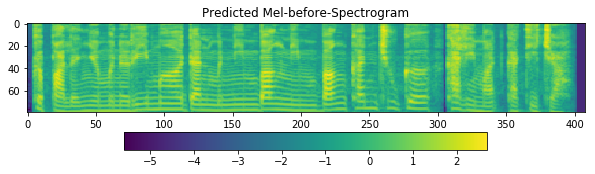

In [14]:
mel_outputs_ = np.reshape(mel_outputs[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

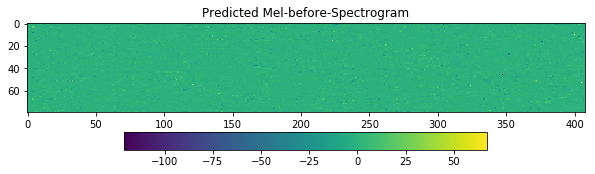

In [15]:
mel_outputs_ = np.reshape(latent[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [16]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-5, beta1 = 0.9, 
                                   beta2 = 0.98, epsilon = 1e-9)

In [ ]:
for k in range(500):
    with tf.GradientTape() as tape:
        losses, attn, latent, mel_hat, ids_slice = model.compute_loss(text = i, textlen = i_lengths, mel = mel_outputs, mellen = mel_lengths)
        loss = losses['kl'] + losses['durloss']
    print(k, losses)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

0 {'kl': <tf.Tensor: id=72323, shape=(), dtype=float32, numpy=2472.8894>, 'durloss': <tf.Tensor: id=72417, shape=(), dtype=float32, numpy=1.2319489>}
1 {'kl': <tf.Tensor: id=126046, shape=(), dtype=float32, numpy=1580.6425>, 'durloss': <tf.Tensor: id=126140, shape=(), dtype=float32, numpy=1.2073131>}
2 {'kl': <tf.Tensor: id=166469, shape=(), dtype=float32, numpy=1150.5863>, 'durloss': <tf.Tensor: id=166563, shape=(), dtype=float32, numpy=1.0807533>}
3 {'kl': <tf.Tensor: id=206892, shape=(), dtype=float32, numpy=900.3066>, 'durloss': <tf.Tensor: id=206986, shape=(), dtype=float32, numpy=1.0492557>}
4 {'kl': <tf.Tensor: id=247315, shape=(), dtype=float32, numpy=707.3982>, 'durloss': <tf.Tensor: id=247409, shape=(), dtype=float32, numpy=0.88687325>}
5 {'kl': <tf.Tensor: id=287738, shape=(), dtype=float32, numpy=603.1236>, 'durloss': <tf.Tensor: id=287832, shape=(), dtype=float32, numpy=0.78003997>}
6 {'kl': <tf.Tensor: id=328161, shape=(), dtype=float32, numpy=518.277>, 'durloss': <tf.Ten

54 {'kl': <tf.Tensor: id=2268465, shape=(), dtype=float32, numpy=76.049866>, 'durloss': <tf.Tensor: id=2268559, shape=(), dtype=float32, numpy=0.17972031>}
55 {'kl': <tf.Tensor: id=2308888, shape=(), dtype=float32, numpy=73.28322>, 'durloss': <tf.Tensor: id=2308982, shape=(), dtype=float32, numpy=0.18939044>}
56 {'kl': <tf.Tensor: id=2349311, shape=(), dtype=float32, numpy=73.0116>, 'durloss': <tf.Tensor: id=2349405, shape=(), dtype=float32, numpy=0.1745082>}
57 {'kl': <tf.Tensor: id=2389734, shape=(), dtype=float32, numpy=72.52675>, 'durloss': <tf.Tensor: id=2389828, shape=(), dtype=float32, numpy=0.17613517>}
58 {'kl': <tf.Tensor: id=2430157, shape=(), dtype=float32, numpy=71.30426>, 'durloss': <tf.Tensor: id=2430251, shape=(), dtype=float32, numpy=0.16571346>}
59 {'kl': <tf.Tensor: id=2470580, shape=(), dtype=float32, numpy=71.39994>, 'durloss': <tf.Tensor: id=2470674, shape=(), dtype=float32, numpy=0.17898819>}
60 {'kl': <tf.Tensor: id=2511003, shape=(), dtype=float32, numpy=70.537

In [ ]:
mel_, mellen_, attn_out = model(inputs = i, lengths = i_lengths)
mel_, mellen_, attn_out

In [ ]:
mel_outputs_ = np.reshape(mel_[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    attn_out[0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [ ]:
# saver = tf.train.Saver()
# saver.save(sess, 'test/model.ckpt')